In [1]:
import math
import torch
from torch import nn

# Model

In [2]:
class Swish(nn.Module):
  def forward(self, x):
    return x * torch.sigmoid(x)

In [3]:
class FeatureEx1d(nn.Module):
  def __init__(self, input_size):
    super().__init__()
    self.layers = nn.Sequential(
        nn.linear(input_size, 256),
        nn.functional.relu(),
        nn.linear(256, 128),
        nn.functional.relu(),
        nn.linear(128, 64),
        nn.functional.relu()
    )

  def forward(self, x):
    return self.layers(x)

In [4]:
class SEblock(nn.Module):
  def __init__(self, ch_in, ch_sq):
    super().__init__()
    self.se = nn.Sequential(
        nn.AdaptiveAvgPool2d(1),
        nn.Conv2d(ch_in, ch_sq, 1),
        Swish(),
        nn.Conv2d(ch_sq, ch_in, 1),
    )
    self.se.apply(weight_init)

  def forward(self, x):
    return x * torch.sigmoid(self.se(x))

def weight_init(m):
  if isinstance(m, nn.Conv2d):
    nn.init.kaiming_normal_(m.weight)

  if isinstance(m, nn.Linear):
    nn.init.kaiming_uniform_(m.weight)
    nn.init.zeros_(m.bias)

In [5]:
class ConvBN(nn.Module):
  def __init__(self, ch_in, ch_out, kernel_size, stride=1, padding=0, groups=1):
    super().__init__()
    self.layers=nn.Sequential(
        nn.Conv2d(ch_in, ch_out, kernel_size, stride, padding, groups=groups, bias=False),
        nn.BatchNorm2d(ch_out),
    )
    self.layers.apply(weight_init)

  def forward(self, x):
    return self.layers(x)

In [6]:
class DropConnect(nn.Module):
  def __init__(self, drop_rate):
    super().__init__()
    self.drop_rate=drop_rate

  def forward(self, x):
    if self.training:
      keep_rate=1.0-self.drop_rate
      r = torch.rand([x.size(0),1,1,1], dtype=x.dtype).to(x.device)
      r+=keep_rate
      mask=r.floor()
      return x.div(keep_rate)*mask
    else:
      return x

In [7]:
class BMConvBlock(nn.Module):
  def __init__(self,ch_in,ch_out,expand_ratio,stride,kernel_size,reduction_ratio=4,drop_connect_rate=0.2):
    super().__init__()
    self.use_residual = (ch_in==ch_out) & (stride==1)
    ch_med = int(ch_in*expand_ratio)
    ch_sq  = max(1, ch_in//reduction_ratio)

    if expand_ratio != 1.0:
      layers = [ConvBN(ch_in, ch_med, 1), Swish()]
    else:
      layers = []
    
    layers.extend([ConvBN(ch_med, ch_med, kernel_size, stride=stride, padding=(kernel_size)//2, groups=ch_med),
                  Swish(),
                  SEblock(ch_med, ch_sq),
                  ConvBN(ch_med, ch_out, 1),
                  ])
    
    if self.use_residual:
      self.drop_connect = DropConnect(drop_connect_rate)

    self.layers = nn.Sequential(*layers)

  def forward(self, x):
    if self.use_residual:
      return x + self.drop_connect(self.layers(x))
    else:
      return self.layers(x)

In [8]:
class Flatten(nn.Module):
  def forward(self, x):
    return x.view(x.shape[0], -1)

In [9]:
class MultiModalNet(nn.Module):
  def __init__(self,
               width_mult=1.0,
               depth_mult=1.0,
               resolution=None,
               dropout_rate=0.2,
               num_classes=4,
               input_ch=3):
    super().__init__()

    # expand_ratio, channel, repeats, stride, kernel_size                   
    settings = [
        [1,  16, 1, 1, 3],  # MBConv1_3x3, SE, 112 -> 112                   
        [6,  24, 2, 2, 3],  # MBConv6_3x3, SE, 112 ->  56                   
        [6,  40, 2, 2, 5],  # MBConv6_5x5, SE,  56 ->  28                   
        [6,  80, 3, 2, 3],  # MBConv6_3x3, SE,  28 ->  14                   
        [6, 112, 3, 1, 5],  # MBConv6_5x5, SE,  14 ->  14                   
        [6, 192, 4, 2, 5],  # MBConv6_5x5, SE,  14 ->   7                   
        [6, 320, 1, 1, 3]   # MBConv6_3x3, SE,   7 ->   7]                  
    ]
    ch_out = int(math.ceil(32*width_mult))
    features = [nn.AdaptiveAvgPool2d(resolution)] if resolution else []
    features.extend([ConvBN(input_ch, ch_out, 3, stride=2), Swish()])     # -> [32, 3, 3, 3]

    ch_in = ch_out
    for t, c, n, s, k in settings:
      ch_out = int(math.ceil(c*width_mult))
      repeats = int(math.ceil(n*depth_mult))
      for i in range(repeats):
        stride = s if i==0 else 1
        features.extend([BMConvBlock(ch_in, ch_out, t, stride, k)])
        ch_in = ch_out

    ch_last = int(math.ceil(1280*width_mult))
    features.extend([ConvBN(ch_in, ch_last, 1), Swish()])

    self.features2d = nn.Sequential(*features)
    self.reshape = nn.Sequential(
        nn.AdaptiveAvgPool2d(1),
        Flatten(),
        nn.Dropout(dropout_rate),
        nn.Linear(ch_last, 128)
    )
    self.classifier = nn.Sequential(
        nn.BatchNorm1d(128*2),
        nn.Linear(128*2, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, num_classes),
        nn.Softmax(dim=1)
    )

  def forward(self, x):
    x1=self.features2d(x[1])
    x1=self.reshape(x1)
    x0=self.features2d(x[0])
    x0=self.reshape(x0)
    x = torch.cat((x0,x1), dim=1)
    x=self.classifier(x)
    return x

# Dataset

In [10]:
import shutil
import os
RESEARCH_WORK_PATH = "/content/drive/MyDrive/Colab Notebooks/BachelorResearch/"


data_dir = "/content/datas/"
if os.path.exists(data_dir):
  shutil.rmtree(data_dir)
for dirs in os.listdir(RESEARCH_WORK_PATH + "MER_audio_taffc_dataset_wav/2s/pickles2/"):
  if "Q" in dirs:
    shutil.copytree(RESEARCH_WORK_PATH + "MER_audio_taffc_dataset_wav/2s/pickles2/" + dirs, data_dir + dirs)

for q in "Q1 Q2 Q3 Q4".split(" "):
  d = RESEARCH_WORK_PATH + "MER_audio_taffc_dataset_wav/2s/pickles2/"  + q + "/"
  print(q, sum(os.path.isfile(os.path.join(d, name)) for name in os.listdir(d)))

for q in "Q1 Q2 Q3 Q4".split(" "):
  d = data_dir + q + "/"
  print(q, sum(os.path.isfile(os.path.join(d, name)) for name in os.listdir(d)))

Q1 2800
Q2 2800
Q3 2800
Q4 2800
Q1 2800
Q2 2800
Q3 2800
Q4 2800


In [11]:
import os
def make_filepath_list(root):
  train_file_list = []
  valid_file_list = []

  for dirs in os.listdir(root):
    if "Q" in dirs:
      file_dir = os.path.join(root, dirs)
      file_list = os.listdir(file_dir)

      for f in file_list:
        position = int(f.split('_')[-1].split('.')[0])
        if position == 0:
          pass
        elif position % 4 ==0:
          valid_file_list += [os.path.join(root, dirs, f)]
        else:
          train_file_list += [os.path.join(root, dirs, f)]
  
  return train_file_list, valid_file_list


In [12]:
from torch.utils import data
import numpy as np
import librosa
import pickle
import torch
import cv2

class musicDataset(data.Dataset):

  def __init__(self, file_list, classes, phase='train'):
    self.file_list = file_list
    self.classes = classes
    self.phase = phase

  def __len__(self):
    return len(self.file_list)


  def __getitem__(self, index):
    pickle_path = self.file_list[index]
    x,y = pickle.load(open(pickle_path, mode="rb"))
    return x, y


train_file_list, valid_file_list = make_filepath_list(data_dir)

print('学習データ数 : ', len(train_file_list))
print(train_file_list[0])

print('検証データ数 : ', len(valid_file_list))
print(valid_file_list[0])

q_classes = "Q1 Q2 Q3 Q4".split(" ")

train_dataset = musicDataset(
    file_list=train_file_list, classes=q_classes, phase='train'
)

valid_dataset = musicDataset(
    file_list=valid_file_list, classes=q_classes, phase='valid'
)


index = 0
print("Dataset1 shape:", train_dataset.__getitem__(index)[0][0].size())
print("Dataset2 shape:", train_dataset.__getitem__(index)[0][1].size())
print("Dataset label:", train_dataset.__getitem__(index)[1])

学習データ数 :  8800
/content/datas/Q4/Q4.MT0007107079_9.wav.pickle
検証データ数 :  2400
/content/datas/Q4/Q4.MT0004537445_12.wav.pickle
Dataset1 shape: torch.Size([1, 87, 384])
Dataset2 shape: torch.Size([1, 173, 257])
Dataset label: 3


# DataLoader

In [13]:
# バッチサイズの指定
batch_size = 64

# DataLoaderを作成
train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count(), pin_memory=True)

valid_dataloader = data.DataLoader(
    valid_dataset, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count(), pin_memory=True)

# pin_mem and num_workers are acceleration technique -> https://qiita.com/sugulu_Ogawa_ISID/items/62f5f7adee083d96a587#11-num_workers

# 辞書にまとめる
dataloaders_dict = {
    'train': train_dataloader, 
    'valid': valid_dataloader
}

# 動作確認
# イテレータに変換
batch_iterator = iter(dataloaders_dict['train'])

# 1番目の要素を取り出す
inputs, labels = next(batch_iterator)

print(inputs[0].size())
print(inputs[1].size())
print(labels)


torch.Size([64, 1, 87, 384])
torch.Size([64, 1, 173, 257])
tensor([2, 3, 2, 3, 0, 2, 1, 3, 0, 3, 0, 3, 3, 1, 2, 3, 3, 3, 1, 3, 0, 0, 3, 3,
        0, 2, 3, 0, 2, 2, 0, 0, 1, 0, 1, 0, 2, 0, 3, 2, 2, 3, 1, 2, 3, 0, 1, 3,
        0, 1, 2, 1, 0, 1, 0, 1, 2, 1, 2, 0, 2, 0, 2, 2])


# Optimizer, Criterion

In [14]:
from torch import optim

model     = MultiModalNet(input_ch=1, num_classes=4).to('cuda')
optimizer = optim.SGD(model.parameters(),lr=0.01)
criterion = nn.CrossEntropyLoss()

# Training

In [15]:
from tqdm import tqdm
from time import time
# エポック数
num_epochs = 200

loss_hist = [[],[]]
acc_hist = [[],[]]

start_time = time()
for epoch in range(num_epochs):
  print('Epoch {}/{}'.format(epoch+1, num_epochs))
  print('-------------')
  
  for phase in ['train', 'valid']:
      
    if phase == 'train':
      # モデルを訓練モードに設定
      model.train()
    else:
      # モデルを推論モードに設定
      model.eval()
    
    # 損失和
    epoch_loss = 0.0
    # 正解数
    epoch_corrects = 0
    
    # DataLoaderからデータをバッチごとに取り出す
    with tqdm(dataloaders_dict[phase],unit='batch',colour='green' if phase == 'train' else 'red') as pbar:
      pbar.set_description('['+phase+'] Epoch %d'% (epoch+1))
      for inputs, labels in pbar:
        inputs = [inputs[0].to('cuda') , inputs[1].to('cuda')]
        labels = labels.to('cuda')
        # optimizerの初期化
        optimizer.zero_grad()
        
        # 学習時のみ勾配を計算させる設定にする
        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          
          # 損失を計算
          loss = criterion(outputs, labels)
          
          # ラベルを予測
          _, preds = torch.max(outputs, 1)
          
          # 訓練時はバックプロパゲーション
          if phase == 'train':
            # 逆伝搬の計算
            loss.backward()
            # パラメータの更新
            optimizer.step()
          
          # イテレーション結果の計算
          # lossの合計を更新
          # PyTorchの仕様上各バッチ内での平均のlossが計算される。
          # データ数を掛けることで平均から合計に変換をしている。
          # 損失和は「全データの損失/データ数」で計算されるため、
          # 平均のままだと損失和を求めることができないため。
          l = loss.item()
          epoch_loss += l * inputs[0].size(0)
          pbar.set_postfix(dict(loss=l))

          # 正解数の合計を更新
          epoch_corrects += torch.sum(preds == labels.data)

    # epochごとのlossと正解率を表示
    epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
    epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)
    loss_hist[0].append(epoch_loss) if phase == 'train' else loss_hist[1].append(epoch_loss)
    acc_hist[0].append(epoch_acc)      if phase == 'train' else acc_hist[1].append(epoch_acc)

    print('[{}] Epoch {} Result: Loss: {:.4f} Acc: {:.4f}\n'.format(phase, epoch+1, epoch_loss, epoch_acc))
print("training time", time() -start_time)

Epoch 1/200
-------------


[train] Epoch 1: 100%|██████████| 138/138 [01:01<00:00,  2.24batch/s, loss=1.38]


[train] Epoch 1 Result: Loss: 1.3813 Acc: 0.3140



[valid] Epoch 1: 100%|██████████| 38/38 [00:03<00:00,  9.95batch/s, loss=1.39]


[valid] Epoch 1 Result: Loss: 1.3864 Acc: 0.2500

Epoch 2/200
-------------


[train] Epoch 2: 100%|██████████| 138/138 [00:54<00:00,  2.55batch/s, loss=1.35]


[train] Epoch 2 Result: Loss: 1.3740 Acc: 0.3372



[valid] Epoch 2: 100%|██████████| 38/38 [00:03<00:00, 10.02batch/s, loss=1.39]


[valid] Epoch 2 Result: Loss: 1.3863 Acc: 0.2500

Epoch 3/200
-------------


[train] Epoch 3: 100%|██████████| 138/138 [00:54<00:00,  2.55batch/s, loss=1.37]


[train] Epoch 3 Result: Loss: 1.3681 Acc: 0.3458



[valid] Epoch 3: 100%|██████████| 38/38 [00:03<00:00,  9.93batch/s, loss=1.39]


[valid] Epoch 3 Result: Loss: 1.3864 Acc: 0.2500

Epoch 4/200
-------------


[train] Epoch 4: 100%|██████████| 138/138 [00:54<00:00,  2.55batch/s, loss=1.36]


[train] Epoch 4 Result: Loss: 1.3630 Acc: 0.3522



[valid] Epoch 4: 100%|██████████| 38/38 [00:03<00:00,  9.88batch/s, loss=1.4]


[valid] Epoch 4 Result: Loss: 1.3865 Acc: 0.2500

Epoch 5/200
-------------


[train] Epoch 5: 100%|██████████| 138/138 [00:54<00:00,  2.55batch/s, loss=1.37]


[train] Epoch 5 Result: Loss: 1.3598 Acc: 0.3573



[valid] Epoch 5: 100%|██████████| 38/38 [00:03<00:00,  9.95batch/s, loss=1.4]


[valid] Epoch 5 Result: Loss: 1.3864 Acc: 0.2500

Epoch 6/200
-------------


[train] Epoch 6: 100%|██████████| 138/138 [00:54<00:00,  2.55batch/s, loss=1.38]


[train] Epoch 6 Result: Loss: 1.3582 Acc: 0.3543



[valid] Epoch 6: 100%|██████████| 38/38 [00:03<00:00,  9.97batch/s, loss=1.41]


[valid] Epoch 6 Result: Loss: 1.3865 Acc: 0.2500

Epoch 7/200
-------------


[train] Epoch 7: 100%|██████████| 138/138 [00:54<00:00,  2.55batch/s, loss=1.35]


[train] Epoch 7 Result: Loss: 1.3521 Acc: 0.3619



[valid] Epoch 7: 100%|██████████| 38/38 [00:03<00:00,  9.80batch/s, loss=1.42]


[valid] Epoch 7 Result: Loss: 1.3866 Acc: 0.2500

Epoch 8/200
-------------


[train] Epoch 8: 100%|██████████| 138/138 [00:54<00:00,  2.55batch/s, loss=1.38]


[train] Epoch 8 Result: Loss: 1.3465 Acc: 0.3681



[valid] Epoch 8: 100%|██████████| 38/38 [00:03<00:00,  9.93batch/s, loss=1.42]


[valid] Epoch 8 Result: Loss: 1.3864 Acc: 0.2513

Epoch 9/200
-------------


[train] Epoch 9: 100%|██████████| 138/138 [00:54<00:00,  2.55batch/s, loss=1.38]


[train] Epoch 9 Result: Loss: 1.3429 Acc: 0.3742



[valid] Epoch 9: 100%|██████████| 38/38 [00:03<00:00,  9.85batch/s, loss=1.43]


[valid] Epoch 9 Result: Loss: 1.3863 Acc: 0.2521

Epoch 10/200
-------------


[train] Epoch 10: 100%|██████████| 138/138 [00:54<00:00,  2.55batch/s, loss=1.36]


[train] Epoch 10 Result: Loss: 1.3415 Acc: 0.3706



[valid] Epoch 10: 100%|██████████| 38/38 [00:03<00:00,  9.86batch/s, loss=1.44]


[valid] Epoch 10 Result: Loss: 1.3863 Acc: 0.2521

Epoch 11/200
-------------


[train] Epoch 11: 100%|██████████| 138/138 [00:54<00:00,  2.55batch/s, loss=1.3]


[train] Epoch 11 Result: Loss: 1.3330 Acc: 0.3833



[valid] Epoch 11: 100%|██████████| 38/38 [00:03<00:00,  9.93batch/s, loss=1.46]


[valid] Epoch 11 Result: Loss: 1.3865 Acc: 0.2521

Epoch 12/200
-------------


[train] Epoch 12: 100%|██████████| 138/138 [00:54<00:00,  2.55batch/s, loss=1.38]


[train] Epoch 12 Result: Loss: 1.3251 Acc: 0.3892



[valid] Epoch 12: 100%|██████████| 38/38 [00:03<00:00,  9.81batch/s, loss=1.47]


[valid] Epoch 12 Result: Loss: 1.3876 Acc: 0.2517

Epoch 13/200
-------------


[train] Epoch 13: 100%|██████████| 138/138 [00:54<00:00,  2.55batch/s, loss=1.25]


[train] Epoch 13 Result: Loss: 1.3227 Acc: 0.3878



[valid] Epoch 13: 100%|██████████| 38/38 [00:03<00:00,  9.93batch/s, loss=1.5]


[valid] Epoch 13 Result: Loss: 1.3900 Acc: 0.2513

Epoch 14/200
-------------


[train] Epoch 14: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.32]


[train] Epoch 14 Result: Loss: 1.3153 Acc: 0.3999



[valid] Epoch 14: 100%|██████████| 38/38 [00:03<00:00,  9.89batch/s, loss=1.53]


[valid] Epoch 14 Result: Loss: 1.3922 Acc: 0.2517

Epoch 15/200
-------------


[train] Epoch 15: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.29]


[train] Epoch 15 Result: Loss: 1.3095 Acc: 0.3991



[valid] Epoch 15: 100%|██████████| 38/38 [00:03<00:00,  9.87batch/s, loss=1.55]


[valid] Epoch 15 Result: Loss: 1.3950 Acc: 0.2508

Epoch 16/200
-------------


[train] Epoch 16: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.33]


[train] Epoch 16 Result: Loss: 1.2994 Acc: 0.4102



[valid] Epoch 16: 100%|██████████| 38/38 [00:03<00:00,  9.97batch/s, loss=1.58]


[valid] Epoch 16 Result: Loss: 1.3984 Acc: 0.2525

Epoch 17/200
-------------


[train] Epoch 17: 100%|██████████| 138/138 [00:54<00:00,  2.55batch/s, loss=1.36]


[train] Epoch 17 Result: Loss: 1.2945 Acc: 0.4080



[valid] Epoch 17: 100%|██████████| 38/38 [00:03<00:00, 10.00batch/s, loss=1.59]


[valid] Epoch 17 Result: Loss: 1.3992 Acc: 0.2533

Epoch 18/200
-------------


[train] Epoch 18: 100%|██████████| 138/138 [00:54<00:00,  2.55batch/s, loss=1.28]


[train] Epoch 18 Result: Loss: 1.2839 Acc: 0.4255



[valid] Epoch 18: 100%|██████████| 38/38 [00:03<00:00,  9.98batch/s, loss=1.61]


[valid] Epoch 18 Result: Loss: 1.4029 Acc: 0.2508

Epoch 19/200
-------------


[train] Epoch 19: 100%|██████████| 138/138 [00:54<00:00,  2.55batch/s, loss=1.31]


[train] Epoch 19 Result: Loss: 1.2763 Acc: 0.4317



[valid] Epoch 19: 100%|██████████| 38/38 [00:03<00:00,  9.82batch/s, loss=1.63]


[valid] Epoch 19 Result: Loss: 1.4074 Acc: 0.2508

Epoch 20/200
-------------


[train] Epoch 20: 100%|██████████| 138/138 [00:54<00:00,  2.55batch/s, loss=1.24]


[train] Epoch 20 Result: Loss: 1.2699 Acc: 0.4375



[valid] Epoch 20: 100%|██████████| 38/38 [00:03<00:00, 10.02batch/s, loss=1.63]


[valid] Epoch 20 Result: Loss: 1.4080 Acc: 0.2521

Epoch 21/200
-------------


[train] Epoch 21: 100%|██████████| 138/138 [00:54<00:00,  2.55batch/s, loss=1.22]


[train] Epoch 21 Result: Loss: 1.2574 Acc: 0.4562



[valid] Epoch 21: 100%|██████████| 38/38 [00:03<00:00,  9.93batch/s, loss=1.64]


[valid] Epoch 21 Result: Loss: 1.4119 Acc: 0.2500

Epoch 22/200
-------------


[train] Epoch 22: 100%|██████████| 138/138 [00:54<00:00,  2.55batch/s, loss=1.15]


[train] Epoch 22 Result: Loss: 1.2500 Acc: 0.4622



[valid] Epoch 22: 100%|██████████| 38/38 [00:03<00:00,  9.86batch/s, loss=1.65]


[valid] Epoch 22 Result: Loss: 1.4127 Acc: 0.2517

Epoch 23/200
-------------


[train] Epoch 23: 100%|██████████| 138/138 [00:54<00:00,  2.55batch/s, loss=1.26]


[train] Epoch 23 Result: Loss: 1.2446 Acc: 0.4676



[valid] Epoch 23: 100%|██████████| 38/38 [00:03<00:00,  9.93batch/s, loss=1.65]


[valid] Epoch 23 Result: Loss: 1.4158 Acc: 0.2500

Epoch 24/200
-------------


[train] Epoch 24: 100%|██████████| 138/138 [00:54<00:00,  2.55batch/s, loss=1.2]


[train] Epoch 24 Result: Loss: 1.2348 Acc: 0.4756



[valid] Epoch 24: 100%|██████████| 38/38 [00:03<00:00,  9.96batch/s, loss=1.65]


[valid] Epoch 24 Result: Loss: 1.4164 Acc: 0.2513

Epoch 25/200
-------------


[train] Epoch 25: 100%|██████████| 138/138 [00:54<00:00,  2.55batch/s, loss=1.17]


[train] Epoch 25 Result: Loss: 1.2330 Acc: 0.4714



[valid] Epoch 25: 100%|██████████| 38/38 [00:03<00:00,  9.85batch/s, loss=1.63]


[valid] Epoch 25 Result: Loss: 1.4146 Acc: 0.2517

Epoch 26/200
-------------


[train] Epoch 26: 100%|██████████| 138/138 [00:54<00:00,  2.55batch/s, loss=1.26]


[train] Epoch 26 Result: Loss: 1.2263 Acc: 0.4859



[valid] Epoch 26: 100%|██████████| 38/38 [00:03<00:00,  9.95batch/s, loss=1.63]


[valid] Epoch 26 Result: Loss: 1.4142 Acc: 0.2550

Epoch 27/200
-------------


[train] Epoch 27: 100%|██████████| 138/138 [00:54<00:00,  2.55batch/s, loss=1.17]


[train] Epoch 27 Result: Loss: 1.2198 Acc: 0.4930



[valid] Epoch 27: 100%|██████████| 38/38 [00:03<00:00,  9.83batch/s, loss=1.63]


[valid] Epoch 27 Result: Loss: 1.4149 Acc: 0.2542

Epoch 28/200
-------------


[train] Epoch 28: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.27]


[train] Epoch 28 Result: Loss: 1.2196 Acc: 0.4920



[valid] Epoch 28: 100%|██████████| 38/38 [00:03<00:00,  9.95batch/s, loss=1.62]


[valid] Epoch 28 Result: Loss: 1.4147 Acc: 0.2550

Epoch 29/200
-------------


[train] Epoch 29: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.15]


[train] Epoch 29 Result: Loss: 1.2130 Acc: 0.5000



[valid] Epoch 29: 100%|██████████| 38/38 [00:03<00:00,  9.85batch/s, loss=1.65]


[valid] Epoch 29 Result: Loss: 1.4178 Acc: 0.2521

Epoch 30/200
-------------


[train] Epoch 30: 100%|██████████| 138/138 [00:54<00:00,  2.55batch/s, loss=1.21]


[train] Epoch 30 Result: Loss: 1.2095 Acc: 0.5039



[valid] Epoch 30: 100%|██████████| 38/38 [00:03<00:00,  9.93batch/s, loss=1.63]


[valid] Epoch 30 Result: Loss: 1.4159 Acc: 0.2529

Epoch 31/200
-------------


[train] Epoch 31: 100%|██████████| 138/138 [00:54<00:00,  2.55batch/s, loss=1.15]


[train] Epoch 31 Result: Loss: 1.2057 Acc: 0.5038



[valid] Epoch 31: 100%|██████████| 38/38 [00:03<00:00,  9.92batch/s, loss=1.64]


[valid] Epoch 31 Result: Loss: 1.4174 Acc: 0.2525

Epoch 32/200
-------------


[train] Epoch 32: 100%|██████████| 138/138 [00:54<00:00,  2.55batch/s, loss=1.28]


[train] Epoch 32 Result: Loss: 1.2048 Acc: 0.5057



[valid] Epoch 32: 100%|██████████| 38/38 [00:03<00:00,  9.86batch/s, loss=1.64]


[valid] Epoch 32 Result: Loss: 1.4188 Acc: 0.2504

Epoch 33/200
-------------


[train] Epoch 33: 100%|██████████| 138/138 [00:54<00:00,  2.55batch/s, loss=1.24]


[train] Epoch 33 Result: Loss: 1.1998 Acc: 0.5180



[valid] Epoch 33: 100%|██████████| 38/38 [00:03<00:00,  9.93batch/s, loss=1.62]


[valid] Epoch 33 Result: Loss: 1.4169 Acc: 0.2538

Epoch 34/200
-------------


[train] Epoch 34: 100%|██████████| 138/138 [00:54<00:00,  2.55batch/s, loss=1.19]


[train] Epoch 34 Result: Loss: 1.1983 Acc: 0.5159



[valid] Epoch 34: 100%|██████████| 38/38 [00:03<00:00,  9.85batch/s, loss=1.64]


[valid] Epoch 34 Result: Loss: 1.4178 Acc: 0.2533

Epoch 35/200
-------------


[train] Epoch 35: 100%|██████████| 138/138 [00:54<00:00,  2.55batch/s, loss=1.23]


[train] Epoch 35 Result: Loss: 1.1957 Acc: 0.5223



[valid] Epoch 35: 100%|██████████| 38/38 [00:03<00:00,  9.95batch/s, loss=1.63]


[valid] Epoch 35 Result: Loss: 1.4168 Acc: 0.2546

Epoch 36/200
-------------


[train] Epoch 36: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.28]


[train] Epoch 36 Result: Loss: 1.1931 Acc: 0.5251



[valid] Epoch 36: 100%|██████████| 38/38 [00:03<00:00,  9.88batch/s, loss=1.62]


[valid] Epoch 36 Result: Loss: 1.4132 Acc: 0.2604

Epoch 37/200
-------------


[train] Epoch 37: 100%|██████████| 138/138 [00:54<00:00,  2.55batch/s, loss=1.16]


[train] Epoch 37 Result: Loss: 1.1889 Acc: 0.5312



[valid] Epoch 37: 100%|██████████| 38/38 [00:03<00:00,  9.91batch/s, loss=1.62]


[valid] Epoch 37 Result: Loss: 1.4135 Acc: 0.2592

Epoch 38/200
-------------


[train] Epoch 38: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.23]


[train] Epoch 38 Result: Loss: 1.1891 Acc: 0.5261



[valid] Epoch 38: 100%|██████████| 38/38 [00:03<00:00,  9.86batch/s, loss=1.61]


[valid] Epoch 38 Result: Loss: 1.4085 Acc: 0.2675

Epoch 39/200
-------------


[train] Epoch 39: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.14]


[train] Epoch 39 Result: Loss: 1.1844 Acc: 0.5316



[valid] Epoch 39: 100%|██████████| 38/38 [00:03<00:00,  9.85batch/s, loss=1.62]


[valid] Epoch 39 Result: Loss: 1.4124 Acc: 0.2638

Epoch 40/200
-------------


[train] Epoch 40: 100%|██████████| 138/138 [00:54<00:00,  2.55batch/s, loss=1.27]


[train] Epoch 40 Result: Loss: 1.1794 Acc: 0.5401



[valid] Epoch 40: 100%|██████████| 38/38 [00:03<00:00,  9.81batch/s, loss=1.63]


[valid] Epoch 40 Result: Loss: 1.4186 Acc: 0.2550

Epoch 41/200
-------------


[train] Epoch 41: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.13]


[train] Epoch 41 Result: Loss: 1.1791 Acc: 0.5407



[valid] Epoch 41: 100%|██████████| 38/38 [00:03<00:00,  9.85batch/s, loss=1.62]


[valid] Epoch 41 Result: Loss: 1.4153 Acc: 0.2625

Epoch 42/200
-------------


[train] Epoch 42: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.12]


[train] Epoch 42 Result: Loss: 1.1778 Acc: 0.5377



[valid] Epoch 42: 100%|██████████| 38/38 [00:03<00:00,  9.78batch/s, loss=1.63]


[valid] Epoch 42 Result: Loss: 1.4168 Acc: 0.2588

Epoch 43/200
-------------


[train] Epoch 43: 100%|██████████| 138/138 [00:54<00:00,  2.55batch/s, loss=1.14]


[train] Epoch 43 Result: Loss: 1.1726 Acc: 0.5478



[valid] Epoch 43: 100%|██████████| 38/38 [00:03<00:00,  9.89batch/s, loss=1.63]


[valid] Epoch 43 Result: Loss: 1.4153 Acc: 0.2633

Epoch 44/200
-------------


[train] Epoch 44: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.28]


[train] Epoch 44 Result: Loss: 1.1759 Acc: 0.5439



[valid] Epoch 44: 100%|██████████| 38/38 [00:03<00:00,  9.92batch/s, loss=1.61]


[valid] Epoch 44 Result: Loss: 1.4056 Acc: 0.2733

Epoch 45/200
-------------


[train] Epoch 45: 100%|██████████| 138/138 [00:54<00:00,  2.55batch/s, loss=1.09]


[train] Epoch 45 Result: Loss: 1.1698 Acc: 0.5545



[valid] Epoch 45: 100%|██████████| 38/38 [00:03<00:00,  9.81batch/s, loss=1.61]


[valid] Epoch 45 Result: Loss: 1.4109 Acc: 0.2700

Epoch 46/200
-------------


[train] Epoch 46: 100%|██████████| 138/138 [00:54<00:00,  2.55batch/s, loss=1.17]


[train] Epoch 46 Result: Loss: 1.1663 Acc: 0.5541



[valid] Epoch 46: 100%|██████████| 38/38 [00:03<00:00,  9.90batch/s, loss=1.6]


[valid] Epoch 46 Result: Loss: 1.4119 Acc: 0.2717

Epoch 47/200
-------------


[train] Epoch 47: 100%|██████████| 138/138 [00:54<00:00,  2.55batch/s, loss=1.12]


[train] Epoch 47 Result: Loss: 1.1624 Acc: 0.5653



[valid] Epoch 47: 100%|██████████| 38/38 [00:03<00:00,  9.95batch/s, loss=1.61]


[valid] Epoch 47 Result: Loss: 1.4154 Acc: 0.2696

Epoch 48/200
-------------


[train] Epoch 48: 100%|██████████| 138/138 [00:54<00:00,  2.55batch/s, loss=1.17]


[train] Epoch 48 Result: Loss: 1.1628 Acc: 0.5601



[valid] Epoch 48: 100%|██████████| 38/38 [00:03<00:00,  9.90batch/s, loss=1.59]


[valid] Epoch 48 Result: Loss: 1.4145 Acc: 0.2742

Epoch 49/200
-------------


[train] Epoch 49: 100%|██████████| 138/138 [00:54<00:00,  2.55batch/s, loss=1.18]


[train] Epoch 49 Result: Loss: 1.1569 Acc: 0.5684



[valid] Epoch 49: 100%|██████████| 38/38 [00:03<00:00,  9.95batch/s, loss=1.57]


[valid] Epoch 49 Result: Loss: 1.4047 Acc: 0.2804

Epoch 50/200
-------------


[train] Epoch 50: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.26]


[train] Epoch 50 Result: Loss: 1.1581 Acc: 0.5682



[valid] Epoch 50: 100%|██████████| 38/38 [00:03<00:00,  9.89batch/s, loss=1.57]


[valid] Epoch 50 Result: Loss: 1.4039 Acc: 0.2812

Epoch 51/200
-------------


[train] Epoch 51: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.21]


[train] Epoch 51 Result: Loss: 1.1540 Acc: 0.5742



[valid] Epoch 51: 100%|██████████| 38/38 [00:03<00:00,  9.83batch/s, loss=1.56]


[valid] Epoch 51 Result: Loss: 1.4047 Acc: 0.2833

Epoch 52/200
-------------


[train] Epoch 52: 100%|██████████| 138/138 [00:54<00:00,  2.55batch/s, loss=1.13]


[train] Epoch 52 Result: Loss: 1.1518 Acc: 0.5778



[valid] Epoch 52: 100%|██████████| 38/38 [00:03<00:00,  9.94batch/s, loss=1.52]


[valid] Epoch 52 Result: Loss: 1.3886 Acc: 0.2996

Epoch 53/200
-------------


[train] Epoch 53: 100%|██████████| 138/138 [00:54<00:00,  2.55batch/s, loss=1.2]


[train] Epoch 53 Result: Loss: 1.1566 Acc: 0.5655



[valid] Epoch 53: 100%|██████████| 38/38 [00:03<00:00,  9.82batch/s, loss=1.5]


[valid] Epoch 53 Result: Loss: 1.3806 Acc: 0.3113

Epoch 54/200
-------------


[train] Epoch 54: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.14]


[train] Epoch 54 Result: Loss: 1.1559 Acc: 0.5664



[valid] Epoch 54: 100%|██████████| 38/38 [00:03<00:00,  9.82batch/s, loss=1.56]


[valid] Epoch 54 Result: Loss: 1.4006 Acc: 0.2896

Epoch 55/200
-------------


[train] Epoch 55: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.05]


[train] Epoch 55 Result: Loss: 1.1485 Acc: 0.5799



[valid] Epoch 55: 100%|██████████| 38/38 [00:03<00:00,  9.87batch/s, loss=1.59]


[valid] Epoch 55 Result: Loss: 1.4174 Acc: 0.2767

Epoch 56/200
-------------


[train] Epoch 56: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.18]


[train] Epoch 56 Result: Loss: 1.1465 Acc: 0.5782



[valid] Epoch 56: 100%|██████████| 38/38 [00:03<00:00,  9.90batch/s, loss=1.52]


[valid] Epoch 56 Result: Loss: 1.3917 Acc: 0.3054

Epoch 57/200
-------------


[train] Epoch 57: 100%|██████████| 138/138 [00:54<00:00,  2.55batch/s, loss=1.07]


[train] Epoch 57 Result: Loss: 1.1439 Acc: 0.5817



[valid] Epoch 57: 100%|██████████| 38/38 [00:03<00:00,  9.89batch/s, loss=1.54]


[valid] Epoch 57 Result: Loss: 1.3957 Acc: 0.2958

Epoch 58/200
-------------


[train] Epoch 58: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.23]


[train] Epoch 58 Result: Loss: 1.1425 Acc: 0.5820



[valid] Epoch 58: 100%|██████████| 38/38 [00:03<00:00,  9.92batch/s, loss=1.53]


[valid] Epoch 58 Result: Loss: 1.3876 Acc: 0.2988

Epoch 59/200
-------------


[train] Epoch 59: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.16]


[train] Epoch 59 Result: Loss: 1.1371 Acc: 0.5890



[valid] Epoch 59: 100%|██████████| 38/38 [00:03<00:00,  9.85batch/s, loss=1.55]


[valid] Epoch 59 Result: Loss: 1.4013 Acc: 0.2958

Epoch 60/200
-------------


[train] Epoch 60: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.21]


[train] Epoch 60 Result: Loss: 1.1358 Acc: 0.5923



[valid] Epoch 60: 100%|██████████| 38/38 [00:03<00:00,  9.96batch/s, loss=1.46]


[valid] Epoch 60 Result: Loss: 1.3611 Acc: 0.3350

Epoch 61/200
-------------


[train] Epoch 61: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.1]


[train] Epoch 61 Result: Loss: 1.1321 Acc: 0.5983



[valid] Epoch 61: 100%|██████████| 38/38 [00:03<00:00,  9.86batch/s, loss=1.49]


[valid] Epoch 61 Result: Loss: 1.3693 Acc: 0.3300

Epoch 62/200
-------------


[train] Epoch 62: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.21]


[train] Epoch 62 Result: Loss: 1.1288 Acc: 0.6036



[valid] Epoch 62: 100%|██████████| 38/38 [00:03<00:00,  9.72batch/s, loss=1.55]


[valid] Epoch 62 Result: Loss: 1.3918 Acc: 0.3146

Epoch 63/200
-------------


[train] Epoch 63: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.11]


[train] Epoch 63 Result: Loss: 1.1310 Acc: 0.5975



[valid] Epoch 63: 100%|██████████| 38/38 [00:03<00:00,  9.80batch/s, loss=1.46]


[valid] Epoch 63 Result: Loss: 1.3655 Acc: 0.3317

Epoch 64/200
-------------


[train] Epoch 64: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.12]


[train] Epoch 64 Result: Loss: 1.1246 Acc: 0.6036



[valid] Epoch 64: 100%|██████████| 38/38 [00:03<00:00,  9.88batch/s, loss=1.47]


[valid] Epoch 64 Result: Loss: 1.3671 Acc: 0.3317

Epoch 65/200
-------------


[train] Epoch 65: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.05]


[train] Epoch 65 Result: Loss: 1.1292 Acc: 0.6044



[valid] Epoch 65: 100%|██████████| 38/38 [00:03<00:00,  9.92batch/s, loss=1.47]


[valid] Epoch 65 Result: Loss: 1.3683 Acc: 0.3292

Epoch 66/200
-------------


[train] Epoch 66: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.16]


[train] Epoch 66 Result: Loss: 1.1213 Acc: 0.6127



[valid] Epoch 66: 100%|██████████| 38/38 [00:03<00:00,  9.94batch/s, loss=1.45]


[valid] Epoch 66 Result: Loss: 1.3690 Acc: 0.3346

Epoch 67/200
-------------


[train] Epoch 67: 100%|██████████| 138/138 [00:54<00:00,  2.55batch/s, loss=1.14]


[train] Epoch 67 Result: Loss: 1.1203 Acc: 0.6147



[valid] Epoch 67: 100%|██████████| 38/38 [00:03<00:00,  9.87batch/s, loss=1.43]


[valid] Epoch 67 Result: Loss: 1.3714 Acc: 0.3371

Epoch 68/200
-------------


[train] Epoch 68: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.12]


[train] Epoch 68 Result: Loss: 1.1163 Acc: 0.6155



[valid] Epoch 68: 100%|██████████| 38/38 [00:03<00:00,  9.84batch/s, loss=1.44]


[valid] Epoch 68 Result: Loss: 1.3650 Acc: 0.3404

Epoch 69/200
-------------


[train] Epoch 69: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.25]


[train] Epoch 69 Result: Loss: 1.1172 Acc: 0.6156



[valid] Epoch 69: 100%|██████████| 38/38 [00:03<00:00,  9.88batch/s, loss=1.55]


[valid] Epoch 69 Result: Loss: 1.4167 Acc: 0.2971

Epoch 70/200
-------------


[train] Epoch 70: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.22]


[train] Epoch 70 Result: Loss: 1.1132 Acc: 0.6232



[valid] Epoch 70: 100%|██████████| 38/38 [00:03<00:00,  9.92batch/s, loss=1.43]


[valid] Epoch 70 Result: Loss: 1.3688 Acc: 0.3425

Epoch 71/200
-------------


[train] Epoch 71: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.07]


[train] Epoch 71 Result: Loss: 1.1131 Acc: 0.6219



[valid] Epoch 71: 100%|██████████| 38/38 [00:03<00:00,  9.87batch/s, loss=1.49]


[valid] Epoch 71 Result: Loss: 1.3858 Acc: 0.3258

Epoch 72/200
-------------


[train] Epoch 72: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.12]


[train] Epoch 72 Result: Loss: 1.1088 Acc: 0.6244



[valid] Epoch 72: 100%|██████████| 38/38 [00:03<00:00,  9.84batch/s, loss=1.47]


[valid] Epoch 72 Result: Loss: 1.3656 Acc: 0.3408

Epoch 73/200
-------------


[train] Epoch 73: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.13]


[train] Epoch 73 Result: Loss: 1.1048 Acc: 0.6298



[valid] Epoch 73: 100%|██████████| 38/38 [00:03<00:00,  9.86batch/s, loss=1.47]


[valid] Epoch 73 Result: Loss: 1.3680 Acc: 0.3371

Epoch 74/200
-------------


[train] Epoch 74: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.2]


[train] Epoch 74 Result: Loss: 1.1053 Acc: 0.6283



[valid] Epoch 74: 100%|██████████| 38/38 [00:03<00:00,  9.82batch/s, loss=1.46]


[valid] Epoch 74 Result: Loss: 1.3766 Acc: 0.3375

Epoch 75/200
-------------


[train] Epoch 75: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.02]


[train] Epoch 75 Result: Loss: 1.1066 Acc: 0.6266



[valid] Epoch 75: 100%|██████████| 38/38 [00:03<00:00,  9.74batch/s, loss=1.51]


[valid] Epoch 75 Result: Loss: 1.4016 Acc: 0.3142

Epoch 76/200
-------------


[train] Epoch 76: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.05]


[train] Epoch 76 Result: Loss: 1.1028 Acc: 0.6305



[valid] Epoch 76: 100%|██████████| 38/38 [00:03<00:00,  9.81batch/s, loss=1.45]


[valid] Epoch 76 Result: Loss: 1.3747 Acc: 0.3367

Epoch 77/200
-------------


[train] Epoch 77: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.18]


[train] Epoch 77 Result: Loss: 1.1002 Acc: 0.6332



[valid] Epoch 77: 100%|██████████| 38/38 [00:03<00:00,  9.82batch/s, loss=1.5]


[valid] Epoch 77 Result: Loss: 1.3929 Acc: 0.3188

Epoch 78/200
-------------


[train] Epoch 78: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.16]


[train] Epoch 78 Result: Loss: 1.0979 Acc: 0.6374



[valid] Epoch 78: 100%|██████████| 38/38 [00:03<00:00,  9.81batch/s, loss=1.41]


[valid] Epoch 78 Result: Loss: 1.3606 Acc: 0.3508

Epoch 79/200
-------------


[train] Epoch 79: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.18]


[train] Epoch 79 Result: Loss: 1.0984 Acc: 0.6358



[valid] Epoch 79: 100%|██████████| 38/38 [00:03<00:00,  9.81batch/s, loss=1.39]


[valid] Epoch 79 Result: Loss: 1.3534 Acc: 0.3546

Epoch 80/200
-------------


[train] Epoch 80: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.08]


[train] Epoch 80 Result: Loss: 1.0892 Acc: 0.6477



[valid] Epoch 80: 100%|██████████| 38/38 [00:03<00:00,  9.91batch/s, loss=1.46]


[valid] Epoch 80 Result: Loss: 1.3762 Acc: 0.3371

Epoch 81/200
-------------


[train] Epoch 81: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.04]


[train] Epoch 81 Result: Loss: 1.0893 Acc: 0.6466



[valid] Epoch 81: 100%|██████████| 38/38 [00:03<00:00,  9.81batch/s, loss=1.46]


[valid] Epoch 81 Result: Loss: 1.3739 Acc: 0.3387

Epoch 82/200
-------------


[train] Epoch 82: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.19]


[train] Epoch 82 Result: Loss: 1.0852 Acc: 0.6527



[valid] Epoch 82: 100%|██████████| 38/38 [00:03<00:00,  9.74batch/s, loss=1.55]


[valid] Epoch 82 Result: Loss: 1.4213 Acc: 0.2996

Epoch 83/200
-------------


[train] Epoch 83: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1]


[train] Epoch 83 Result: Loss: 1.0884 Acc: 0.6482



[valid] Epoch 83: 100%|██████████| 38/38 [00:03<00:00,  9.72batch/s, loss=1.48]


[valid] Epoch 83 Result: Loss: 1.3897 Acc: 0.3292

Epoch 84/200
-------------


[train] Epoch 84: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.05]


[train] Epoch 84 Result: Loss: 1.0843 Acc: 0.6503



[valid] Epoch 84: 100%|██████████| 38/38 [00:03<00:00,  9.77batch/s, loss=1.43]


[valid] Epoch 84 Result: Loss: 1.3596 Acc: 0.3488

Epoch 85/200
-------------


[train] Epoch 85: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.18]


[train] Epoch 85 Result: Loss: 1.0876 Acc: 0.6477



[valid] Epoch 85: 100%|██████████| 38/38 [00:03<00:00,  9.89batch/s, loss=1.45]


[valid] Epoch 85 Result: Loss: 1.3668 Acc: 0.3425

Epoch 86/200
-------------


[train] Epoch 86: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.19]


[train] Epoch 86 Result: Loss: 1.0832 Acc: 0.6493



[valid] Epoch 86: 100%|██████████| 38/38 [00:03<00:00,  9.72batch/s, loss=1.41]


[valid] Epoch 86 Result: Loss: 1.3447 Acc: 0.3713

Epoch 87/200
-------------


[train] Epoch 87: 100%|██████████| 138/138 [00:54<00:00,  2.55batch/s, loss=1.17]


[train] Epoch 87 Result: Loss: 1.0805 Acc: 0.6566



[valid] Epoch 87: 100%|██████████| 38/38 [00:04<00:00,  9.42batch/s, loss=1.49]


[valid] Epoch 87 Result: Loss: 1.3805 Acc: 0.3321

Epoch 88/200
-------------


[train] Epoch 88: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.13]


[train] Epoch 88 Result: Loss: 1.0772 Acc: 0.6595



[valid] Epoch 88: 100%|██████████| 38/38 [00:03<00:00,  9.83batch/s, loss=1.4]


[valid] Epoch 88 Result: Loss: 1.3443 Acc: 0.3688

Epoch 89/200
-------------


[train] Epoch 89: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.08]


[train] Epoch 89 Result: Loss: 1.0713 Acc: 0.6661



[valid] Epoch 89: 100%|██████████| 38/38 [00:03<00:00,  9.83batch/s, loss=1.48]


[valid] Epoch 89 Result: Loss: 1.3853 Acc: 0.3350

Epoch 90/200
-------------


[train] Epoch 90: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.11]


[train] Epoch 90 Result: Loss: 1.0717 Acc: 0.6672



[valid] Epoch 90: 100%|██████████| 38/38 [00:03<00:00,  9.87batch/s, loss=1.43]


[valid] Epoch 90 Result: Loss: 1.3721 Acc: 0.3433

Epoch 91/200
-------------


[train] Epoch 91: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.06]


[train] Epoch 91 Result: Loss: 1.0782 Acc: 0.6602



[valid] Epoch 91: 100%|██████████| 38/38 [00:03<00:00,  9.79batch/s, loss=1.3]


[valid] Epoch 91 Result: Loss: 1.3132 Acc: 0.3958

Epoch 92/200
-------------


[train] Epoch 92: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.23]


[train] Epoch 92 Result: Loss: 1.0710 Acc: 0.6674



[valid] Epoch 92: 100%|██████████| 38/38 [00:03<00:00,  9.85batch/s, loss=1.32]


[valid] Epoch 92 Result: Loss: 1.3333 Acc: 0.3800

Epoch 93/200
-------------


[train] Epoch 93: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.01]


[train] Epoch 93 Result: Loss: 1.0693 Acc: 0.6657



[valid] Epoch 93: 100%|██████████| 38/38 [00:03<00:00,  9.86batch/s, loss=1.47]


[valid] Epoch 93 Result: Loss: 1.3835 Acc: 0.3400

Epoch 94/200
-------------


[train] Epoch 94: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=0.94]


[train] Epoch 94 Result: Loss: 1.0609 Acc: 0.6805



[valid] Epoch 94: 100%|██████████| 38/38 [00:03<00:00,  9.80batch/s, loss=1.51]


[valid] Epoch 94 Result: Loss: 1.4062 Acc: 0.3238

Epoch 95/200
-------------


[train] Epoch 95: 100%|██████████| 138/138 [00:54<00:00,  2.55batch/s, loss=1.19]


[train] Epoch 95 Result: Loss: 1.0633 Acc: 0.6768



[valid] Epoch 95: 100%|██████████| 38/38 [00:03<00:00,  9.85batch/s, loss=1.43]


[valid] Epoch 95 Result: Loss: 1.3731 Acc: 0.3508

Epoch 96/200
-------------


[train] Epoch 96: 100%|██████████| 138/138 [00:54<00:00,  2.55batch/s, loss=1.02]


[train] Epoch 96 Result: Loss: 1.0584 Acc: 0.6775



[valid] Epoch 96: 100%|██████████| 38/38 [00:03<00:00,  9.88batch/s, loss=1.43]


[valid] Epoch 96 Result: Loss: 1.3688 Acc: 0.3508

Epoch 97/200
-------------


[train] Epoch 97: 100%|██████████| 138/138 [00:54<00:00,  2.55batch/s, loss=1.03]


[train] Epoch 97 Result: Loss: 1.0578 Acc: 0.6807



[valid] Epoch 97: 100%|██████████| 38/38 [00:03<00:00,  9.91batch/s, loss=1.45]


[valid] Epoch 97 Result: Loss: 1.3797 Acc: 0.3425

Epoch 98/200
-------------


[train] Epoch 98: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.16]


[train] Epoch 98 Result: Loss: 1.0595 Acc: 0.6816



[valid] Epoch 98: 100%|██████████| 38/38 [00:03<00:00,  9.89batch/s, loss=1.4]


[valid] Epoch 98 Result: Loss: 1.3547 Acc: 0.3638

Epoch 99/200
-------------


[train] Epoch 99: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.04]


[train] Epoch 99 Result: Loss: 1.0581 Acc: 0.6785



[valid] Epoch 99: 100%|██████████| 38/38 [00:03<00:00,  9.84batch/s, loss=1.32]


[valid] Epoch 99 Result: Loss: 1.3357 Acc: 0.3813

Epoch 100/200
-------------


[train] Epoch 100: 100%|██████████| 138/138 [00:54<00:00,  2.55batch/s, loss=0.956]


[train] Epoch 100 Result: Loss: 1.0541 Acc: 0.6819



[valid] Epoch 100: 100%|██████████| 38/38 [00:03<00:00,  9.86batch/s, loss=1.39]


[valid] Epoch 100 Result: Loss: 1.3582 Acc: 0.3663

Epoch 101/200
-------------


[train] Epoch 101: 100%|██████████| 138/138 [00:54<00:00,  2.55batch/s, loss=1.09]


[train] Epoch 101 Result: Loss: 1.0562 Acc: 0.6809



[valid] Epoch 101: 100%|██████████| 38/38 [00:03<00:00,  9.91batch/s, loss=1.37]


[valid] Epoch 101 Result: Loss: 1.3347 Acc: 0.3833

Epoch 102/200
-------------


[train] Epoch 102: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=0.988]


[train] Epoch 102 Result: Loss: 1.0460 Acc: 0.6935



[valid] Epoch 102: 100%|██████████| 38/38 [00:03<00:00,  9.85batch/s, loss=1.35]


[valid] Epoch 102 Result: Loss: 1.3346 Acc: 0.3788

Epoch 103/200
-------------


[train] Epoch 103: 100%|██████████| 138/138 [00:54<00:00,  2.55batch/s, loss=1.05]


[train] Epoch 103 Result: Loss: 1.0542 Acc: 0.6808



[valid] Epoch 103: 100%|██████████| 38/38 [00:03<00:00,  9.78batch/s, loss=1.15]


[valid] Epoch 103 Result: Loss: 1.3115 Acc: 0.4046

Epoch 104/200
-------------


[train] Epoch 104: 100%|██████████| 138/138 [00:54<00:00,  2.55batch/s, loss=1.08]


[train] Epoch 104 Result: Loss: 1.0531 Acc: 0.6851



[valid] Epoch 104: 100%|██████████| 38/38 [00:03<00:00,  9.80batch/s, loss=1.37]


[valid] Epoch 104 Result: Loss: 1.3458 Acc: 0.3742

Epoch 105/200
-------------


[train] Epoch 105: 100%|██████████| 138/138 [00:54<00:00,  2.55batch/s, loss=1.03]


[train] Epoch 105 Result: Loss: 1.0493 Acc: 0.6884



[valid] Epoch 105: 100%|██████████| 38/38 [00:03<00:00,  9.92batch/s, loss=1.14]


[valid] Epoch 105 Result: Loss: 1.2992 Acc: 0.4138

Epoch 106/200
-------------


[train] Epoch 106: 100%|██████████| 138/138 [00:54<00:00,  2.55batch/s, loss=1.07]


[train] Epoch 106 Result: Loss: 1.0459 Acc: 0.6928



[valid] Epoch 106: 100%|██████████| 38/38 [00:03<00:00,  9.81batch/s, loss=1.26]


[valid] Epoch 106 Result: Loss: 1.3161 Acc: 0.3983

Epoch 107/200
-------------


[train] Epoch 107: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.06]


[train] Epoch 107 Result: Loss: 1.0355 Acc: 0.7032



[valid] Epoch 107: 100%|██████████| 38/38 [00:03<00:00,  9.87batch/s, loss=1.32]


[valid] Epoch 107 Result: Loss: 1.3243 Acc: 0.3983

Epoch 108/200
-------------


[train] Epoch 108: 100%|██████████| 138/138 [00:54<00:00,  2.55batch/s, loss=1.14]


[train] Epoch 108 Result: Loss: 1.0432 Acc: 0.6943



[valid] Epoch 108: 100%|██████████| 38/38 [00:03<00:00,  9.90batch/s, loss=1.37]


[valid] Epoch 108 Result: Loss: 1.3538 Acc: 0.3663

Epoch 109/200
-------------


[train] Epoch 109: 100%|██████████| 138/138 [00:54<00:00,  2.55batch/s, loss=1.13]


[train] Epoch 109 Result: Loss: 1.0377 Acc: 0.7006



[valid] Epoch 109: 100%|██████████| 38/38 [00:03<00:00,  9.79batch/s, loss=1.35]


[valid] Epoch 109 Result: Loss: 1.3407 Acc: 0.3796

Epoch 110/200
-------------


[train] Epoch 110: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.1]


[train] Epoch 110 Result: Loss: 1.0348 Acc: 0.7055



[valid] Epoch 110: 100%|██████████| 38/38 [00:03<00:00,  9.86batch/s, loss=1.4]


[valid] Epoch 110 Result: Loss: 1.3417 Acc: 0.3775

Epoch 111/200
-------------


[train] Epoch 111: 100%|██████████| 138/138 [00:54<00:00,  2.55batch/s, loss=1.13]


[train] Epoch 111 Result: Loss: 1.0380 Acc: 0.6999



[valid] Epoch 111: 100%|██████████| 38/38 [00:03<00:00,  9.91batch/s, loss=1.47]


[valid] Epoch 111 Result: Loss: 1.3696 Acc: 0.3525

Epoch 112/200
-------------


[train] Epoch 112: 100%|██████████| 138/138 [00:54<00:00,  2.55batch/s, loss=0.913]


[train] Epoch 112 Result: Loss: 1.0308 Acc: 0.7083



[valid] Epoch 112: 100%|██████████| 38/38 [00:03<00:00,  9.91batch/s, loss=1.42]


[valid] Epoch 112 Result: Loss: 1.3492 Acc: 0.3746

Epoch 113/200
-------------


[train] Epoch 113: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.06]


[train] Epoch 113 Result: Loss: 1.0276 Acc: 0.7134



[valid] Epoch 113: 100%|██████████| 38/38 [00:03<00:00,  9.91batch/s, loss=1.33]


[valid] Epoch 113 Result: Loss: 1.3237 Acc: 0.3908

Epoch 114/200
-------------


[train] Epoch 114: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.07]


[train] Epoch 114 Result: Loss: 1.0237 Acc: 0.7164



[valid] Epoch 114: 100%|██████████| 38/38 [00:03<00:00,  9.88batch/s, loss=1.39]


[valid] Epoch 114 Result: Loss: 1.3404 Acc: 0.3813

Epoch 115/200
-------------


[train] Epoch 115: 100%|██████████| 138/138 [00:54<00:00,  2.55batch/s, loss=0.921]


[train] Epoch 115 Result: Loss: 1.0245 Acc: 0.7148



[valid] Epoch 115: 100%|██████████| 38/38 [00:03<00:00,  9.90batch/s, loss=1.32]


[valid] Epoch 115 Result: Loss: 1.3120 Acc: 0.4133

Epoch 116/200
-------------


[train] Epoch 116: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.08]


[train] Epoch 116 Result: Loss: 1.0301 Acc: 0.7080



[valid] Epoch 116: 100%|██████████| 38/38 [00:03<00:00,  9.89batch/s, loss=1.36]


[valid] Epoch 116 Result: Loss: 1.3211 Acc: 0.4013

Epoch 117/200
-------------


[train] Epoch 117: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.01]


[train] Epoch 117 Result: Loss: 1.0205 Acc: 0.7192



[valid] Epoch 117: 100%|██████████| 38/38 [00:03<00:00,  9.88batch/s, loss=1.48]


[valid] Epoch 117 Result: Loss: 1.3718 Acc: 0.3550

Epoch 118/200
-------------


[train] Epoch 118: 100%|██████████| 138/138 [00:54<00:00,  2.55batch/s, loss=1.11]


[train] Epoch 118 Result: Loss: 1.0222 Acc: 0.7172



[valid] Epoch 118: 100%|██████████| 38/38 [00:03<00:00,  9.93batch/s, loss=1.45]


[valid] Epoch 118 Result: Loss: 1.3616 Acc: 0.3629

Epoch 119/200
-------------


[train] Epoch 119: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.09]


[train] Epoch 119 Result: Loss: 1.0186 Acc: 0.7194



[valid] Epoch 119: 100%|██████████| 38/38 [00:03<00:00,  9.77batch/s, loss=1.44]


[valid] Epoch 119 Result: Loss: 1.3455 Acc: 0.3796

Epoch 120/200
-------------


[train] Epoch 120: 100%|██████████| 138/138 [00:54<00:00,  2.55batch/s, loss=1.04]


[train] Epoch 120 Result: Loss: 1.0259 Acc: 0.7148



[valid] Epoch 120: 100%|██████████| 38/38 [00:03<00:00,  9.84batch/s, loss=1.37]


[valid] Epoch 120 Result: Loss: 1.3394 Acc: 0.3804

Epoch 121/200
-------------


[train] Epoch 121: 100%|██████████| 138/138 [00:54<00:00,  2.55batch/s, loss=0.987]


[train] Epoch 121 Result: Loss: 1.0172 Acc: 0.7214



[valid] Epoch 121: 100%|██████████| 38/38 [00:03<00:00,  9.81batch/s, loss=1.42]


[valid] Epoch 121 Result: Loss: 1.3507 Acc: 0.3758

Epoch 122/200
-------------


[train] Epoch 122: 100%|██████████| 138/138 [00:54<00:00,  2.55batch/s, loss=1.09]


[train] Epoch 122 Result: Loss: 1.0187 Acc: 0.7199



[valid] Epoch 122: 100%|██████████| 38/38 [00:03<00:00,  9.91batch/s, loss=1.44]


[valid] Epoch 122 Result: Loss: 1.3535 Acc: 0.3675

Epoch 123/200
-------------


[train] Epoch 123: 100%|██████████| 138/138 [00:54<00:00,  2.55batch/s, loss=0.983]


[train] Epoch 123 Result: Loss: 1.0182 Acc: 0.7201



[valid] Epoch 123: 100%|██████████| 38/38 [00:03<00:00,  9.93batch/s, loss=1.5]


[valid] Epoch 123 Result: Loss: 1.3819 Acc: 0.3429

Epoch 124/200
-------------


[train] Epoch 124: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.04]


[train] Epoch 124 Result: Loss: 1.0175 Acc: 0.7208



[valid] Epoch 124: 100%|██████████| 38/38 [00:03<00:00,  9.87batch/s, loss=1.4]


[valid] Epoch 124 Result: Loss: 1.3338 Acc: 0.3883

Epoch 125/200
-------------


[train] Epoch 125: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=0.98]


[train] Epoch 125 Result: Loss: 1.0175 Acc: 0.7185



[valid] Epoch 125: 100%|██████████| 38/38 [00:03<00:00,  9.88batch/s, loss=1.37]


[valid] Epoch 125 Result: Loss: 1.3340 Acc: 0.3829

Epoch 126/200
-------------


[train] Epoch 126: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.13]


[train] Epoch 126 Result: Loss: 1.0108 Acc: 0.7250



[valid] Epoch 126: 100%|██████████| 38/38 [00:03<00:00,  9.88batch/s, loss=1.51]


[valid] Epoch 126 Result: Loss: 1.3862 Acc: 0.3429

Epoch 127/200
-------------


[train] Epoch 127: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=0.925]


[train] Epoch 127 Result: Loss: 1.0192 Acc: 0.7175



[valid] Epoch 127: 100%|██████████| 38/38 [00:03<00:00,  9.81batch/s, loss=1.12]


[valid] Epoch 127 Result: Loss: 1.3045 Acc: 0.4154

Epoch 128/200
-------------


[train] Epoch 128: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=0.995]


[train] Epoch 128 Result: Loss: 1.0065 Acc: 0.7324



[valid] Epoch 128: 100%|██████████| 38/38 [00:03<00:00,  9.83batch/s, loss=1.46]


[valid] Epoch 128 Result: Loss: 1.3616 Acc: 0.3625

Epoch 129/200
-------------


[train] Epoch 129: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=0.952]


[train] Epoch 129 Result: Loss: 1.0068 Acc: 0.7333



[valid] Epoch 129: 100%|██████████| 38/38 [00:03<00:00,  9.84batch/s, loss=1.35]


[valid] Epoch 129 Result: Loss: 1.3261 Acc: 0.3983

Epoch 130/200
-------------


[train] Epoch 130: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.01]


[train] Epoch 130 Result: Loss: 1.0026 Acc: 0.7382



[valid] Epoch 130: 100%|██████████| 38/38 [00:03<00:00,  9.79batch/s, loss=1.26]


[valid] Epoch 130 Result: Loss: 1.3109 Acc: 0.4088

Epoch 131/200
-------------


[train] Epoch 131: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.04]


[train] Epoch 131 Result: Loss: 1.0067 Acc: 0.7330



[valid] Epoch 131: 100%|██████████| 38/38 [00:03<00:00,  9.78batch/s, loss=1.46]


[valid] Epoch 131 Result: Loss: 1.3758 Acc: 0.3508

Epoch 132/200
-------------


[train] Epoch 132: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.04]


[train] Epoch 132 Result: Loss: 1.0025 Acc: 0.7362



[valid] Epoch 132: 100%|██████████| 38/38 [00:03<00:00,  9.78batch/s, loss=1.38]


[valid] Epoch 132 Result: Loss: 1.3457 Acc: 0.3779

Epoch 133/200
-------------


[train] Epoch 133: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.08]


[train] Epoch 133 Result: Loss: 1.0008 Acc: 0.7362



[valid] Epoch 133: 100%|██████████| 38/38 [00:03<00:00,  9.87batch/s, loss=1.29]


[valid] Epoch 133 Result: Loss: 1.3307 Acc: 0.3929

Epoch 134/200
-------------


[train] Epoch 134: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=0.929]


[train] Epoch 134 Result: Loss: 0.9911 Acc: 0.7517



[valid] Epoch 134: 100%|██████████| 38/38 [00:03<00:00,  9.78batch/s, loss=1.46]


[valid] Epoch 134 Result: Loss: 1.3597 Acc: 0.3654

Epoch 135/200
-------------


[train] Epoch 135: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.03]


[train] Epoch 135 Result: Loss: 0.9986 Acc: 0.7426



[valid] Epoch 135: 100%|██████████| 38/38 [00:03<00:00,  9.66batch/s, loss=1.38]


[valid] Epoch 135 Result: Loss: 1.3323 Acc: 0.3871

Epoch 136/200
-------------


[train] Epoch 136: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.03]


[train] Epoch 136 Result: Loss: 0.9945 Acc: 0.7452



[valid] Epoch 136: 100%|██████████| 38/38 [00:03<00:00,  9.82batch/s, loss=1.3]


[valid] Epoch 136 Result: Loss: 1.3221 Acc: 0.4008

Epoch 137/200
-------------


[train] Epoch 137: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.02]


[train] Epoch 137 Result: Loss: 0.9923 Acc: 0.7494



[valid] Epoch 137: 100%|██████████| 38/38 [00:03<00:00,  9.92batch/s, loss=1.18]


[valid] Epoch 137 Result: Loss: 1.3008 Acc: 0.4150

Epoch 138/200
-------------


[train] Epoch 138: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=0.987]


[train] Epoch 138 Result: Loss: 0.9929 Acc: 0.7473



[valid] Epoch 138: 100%|██████████| 38/38 [00:03<00:00,  9.82batch/s, loss=1.19]


[valid] Epoch 138 Result: Loss: 1.2946 Acc: 0.4200

Epoch 139/200
-------------


[train] Epoch 139: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=0.957]


[train] Epoch 139 Result: Loss: 0.9922 Acc: 0.7484



[valid] Epoch 139: 100%|██████████| 38/38 [00:03<00:00,  9.84batch/s, loss=1.23]


[valid] Epoch 139 Result: Loss: 1.3096 Acc: 0.4142

Epoch 140/200
-------------


[train] Epoch 140: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.01]


[train] Epoch 140 Result: Loss: 0.9884 Acc: 0.7507



[valid] Epoch 140: 100%|██████████| 38/38 [00:03<00:00,  9.57batch/s, loss=1.37]


[valid] Epoch 140 Result: Loss: 1.3145 Acc: 0.4100

Epoch 141/200
-------------


[train] Epoch 141: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.12]


[train] Epoch 141 Result: Loss: 0.9837 Acc: 0.7568



[valid] Epoch 141: 100%|██████████| 38/38 [00:03<00:00,  9.85batch/s, loss=1.2]


[valid] Epoch 141 Result: Loss: 1.3089 Acc: 0.4125

Epoch 142/200
-------------


[train] Epoch 142: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.03]


[train] Epoch 142 Result: Loss: 0.9934 Acc: 0.7432



[valid] Epoch 142: 100%|██████████| 38/38 [00:03<00:00,  9.85batch/s, loss=1.3]


[valid] Epoch 142 Result: Loss: 1.3200 Acc: 0.4058

Epoch 143/200
-------------


[train] Epoch 143: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=0.961]


[train] Epoch 143 Result: Loss: 0.9954 Acc: 0.7456



[valid] Epoch 143: 100%|██████████| 38/38 [00:03<00:00,  9.71batch/s, loss=1.31]


[valid] Epoch 143 Result: Loss: 1.3166 Acc: 0.4092

Epoch 144/200
-------------


[train] Epoch 144: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.06]


[train] Epoch 144 Result: Loss: 0.9873 Acc: 0.7541



[valid] Epoch 144: 100%|██████████| 38/38 [00:03<00:00,  9.84batch/s, loss=1.33]


[valid] Epoch 144 Result: Loss: 1.3151 Acc: 0.4117

Epoch 145/200
-------------


[train] Epoch 145: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=0.874]


[train] Epoch 145 Result: Loss: 0.9897 Acc: 0.7489



[valid] Epoch 145: 100%|██████████| 38/38 [00:03<00:00,  9.75batch/s, loss=1.42]


[valid] Epoch 145 Result: Loss: 1.3361 Acc: 0.3871

Epoch 146/200
-------------


[train] Epoch 146: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=0.994]


[train] Epoch 146 Result: Loss: 0.9813 Acc: 0.7597



[valid] Epoch 146: 100%|██████████| 38/38 [00:03<00:00,  9.83batch/s, loss=1.35]


[valid] Epoch 146 Result: Loss: 1.3127 Acc: 0.4154

Epoch 147/200
-------------


[train] Epoch 147: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=0.899]


[train] Epoch 147 Result: Loss: 0.9835 Acc: 0.7562



[valid] Epoch 147: 100%|██████████| 38/38 [00:03<00:00,  9.78batch/s, loss=1.34]


[valid] Epoch 147 Result: Loss: 1.3393 Acc: 0.3846

Epoch 148/200
-------------


[train] Epoch 148: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.02]


[train] Epoch 148 Result: Loss: 0.9828 Acc: 0.7580



[valid] Epoch 148: 100%|██████████| 38/38 [00:03<00:00,  9.78batch/s, loss=1.18]


[valid] Epoch 148 Result: Loss: 1.3041 Acc: 0.4129

Epoch 149/200
-------------


[train] Epoch 149: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=0.939]


[train] Epoch 149 Result: Loss: 0.9827 Acc: 0.7557



[valid] Epoch 149: 100%|██████████| 38/38 [00:03<00:00,  9.81batch/s, loss=1.26]


[valid] Epoch 149 Result: Loss: 1.3233 Acc: 0.4033

Epoch 150/200
-------------


[train] Epoch 150: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=0.915]


[train] Epoch 150 Result: Loss: 0.9810 Acc: 0.7590



[valid] Epoch 150: 100%|██████████| 38/38 [00:03<00:00,  9.84batch/s, loss=1.26]


[valid] Epoch 150 Result: Loss: 1.3108 Acc: 0.4146

Epoch 151/200
-------------


[train] Epoch 151: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=0.936]


[train] Epoch 151 Result: Loss: 0.9802 Acc: 0.7609



[valid] Epoch 151: 100%|██████████| 38/38 [00:03<00:00,  9.89batch/s, loss=1.2]


[valid] Epoch 151 Result: Loss: 1.2959 Acc: 0.4296

Epoch 152/200
-------------


[train] Epoch 152: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=0.991]


[train] Epoch 152 Result: Loss: 0.9804 Acc: 0.7591



[valid] Epoch 152: 100%|██████████| 38/38 [00:03<00:00,  9.82batch/s, loss=1.35]


[valid] Epoch 152 Result: Loss: 1.3186 Acc: 0.4083

Epoch 153/200
-------------


[train] Epoch 153: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.02]


[train] Epoch 153 Result: Loss: 0.9772 Acc: 0.7645



[valid] Epoch 153: 100%|██████████| 38/38 [00:03<00:00,  9.83batch/s, loss=1.31]


[valid] Epoch 153 Result: Loss: 1.3158 Acc: 0.4092

Epoch 154/200
-------------


[train] Epoch 154: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=0.944]


[train] Epoch 154 Result: Loss: 0.9731 Acc: 0.7681



[valid] Epoch 154: 100%|██████████| 38/38 [00:03<00:00,  9.76batch/s, loss=1.24]


[valid] Epoch 154 Result: Loss: 1.3153 Acc: 0.4163

Epoch 155/200
-------------


[train] Epoch 155: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=0.916]


[train] Epoch 155 Result: Loss: 0.9725 Acc: 0.7691



[valid] Epoch 155: 100%|██████████| 38/38 [00:03<00:00,  9.83batch/s, loss=1.22]


[valid] Epoch 155 Result: Loss: 1.3189 Acc: 0.4079

Epoch 156/200
-------------


[train] Epoch 156: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=0.981]


[train] Epoch 156 Result: Loss: 0.9786 Acc: 0.7603



[valid] Epoch 156: 100%|██████████| 38/38 [00:03<00:00,  9.84batch/s, loss=1.24]


[valid] Epoch 156 Result: Loss: 1.3267 Acc: 0.3975

Epoch 157/200
-------------


[train] Epoch 157: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=0.928]


[train] Epoch 157 Result: Loss: 0.9717 Acc: 0.7699



[valid] Epoch 157: 100%|██████████| 38/38 [00:03<00:00,  9.82batch/s, loss=1.51]


[valid] Epoch 157 Result: Loss: 1.3683 Acc: 0.3621

Epoch 158/200
-------------


[train] Epoch 158: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=0.957]


[train] Epoch 158 Result: Loss: 0.9725 Acc: 0.7667



[valid] Epoch 158: 100%|██████████| 38/38 [00:03<00:00,  9.82batch/s, loss=1.02]


[valid] Epoch 158 Result: Loss: 1.3191 Acc: 0.3963

Epoch 159/200
-------------


[train] Epoch 159: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=0.971]


[train] Epoch 159 Result: Loss: 0.9713 Acc: 0.7680



[valid] Epoch 159: 100%|██████████| 38/38 [00:03<00:00,  9.78batch/s, loss=1.24]


[valid] Epoch 159 Result: Loss: 1.3180 Acc: 0.4062

Epoch 160/200
-------------


[train] Epoch 160: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1]


[train] Epoch 160 Result: Loss: 0.9649 Acc: 0.7777



[valid] Epoch 160: 100%|██████████| 38/38 [00:03<00:00,  9.79batch/s, loss=1.17]


[valid] Epoch 160 Result: Loss: 1.3131 Acc: 0.4079

Epoch 161/200
-------------


[train] Epoch 161: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=0.948]


[train] Epoch 161 Result: Loss: 0.9683 Acc: 0.7719



[valid] Epoch 161: 100%|██████████| 38/38 [00:03<00:00,  9.85batch/s, loss=1.3]


[valid] Epoch 161 Result: Loss: 1.3146 Acc: 0.4117

Epoch 162/200
-------------


[train] Epoch 162: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=0.993]


[train] Epoch 162 Result: Loss: 0.9578 Acc: 0.7841



[valid] Epoch 162: 100%|██████████| 38/38 [00:03<00:00,  9.86batch/s, loss=1.37]


[valid] Epoch 162 Result: Loss: 1.3258 Acc: 0.4054

Epoch 163/200
-------------


[train] Epoch 163: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=0.954]


[train] Epoch 163 Result: Loss: 0.9691 Acc: 0.7699



[valid] Epoch 163: 100%|██████████| 38/38 [00:03<00:00,  9.88batch/s, loss=1.25]


[valid] Epoch 163 Result: Loss: 1.3278 Acc: 0.3979

Epoch 164/200
-------------


[train] Epoch 164: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=0.977]


[train] Epoch 164 Result: Loss: 0.9649 Acc: 0.7744



[valid] Epoch 164: 100%|██████████| 38/38 [00:03<00:00,  9.80batch/s, loss=1.36]


[valid] Epoch 164 Result: Loss: 1.3372 Acc: 0.3867

Epoch 165/200
-------------


[train] Epoch 165: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=0.979]


[train] Epoch 165 Result: Loss: 0.9608 Acc: 0.7793



[valid] Epoch 165: 100%|██████████| 38/38 [00:03<00:00,  9.84batch/s, loss=0.991]


[valid] Epoch 165 Result: Loss: 1.3137 Acc: 0.4050

Epoch 166/200
-------------


[train] Epoch 166: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=0.826]


[train] Epoch 166 Result: Loss: 0.9628 Acc: 0.7777



[valid] Epoch 166: 100%|██████████| 38/38 [00:03<00:00,  9.84batch/s, loss=1.33]


[valid] Epoch 166 Result: Loss: 1.3146 Acc: 0.4138

Epoch 167/200
-------------


[train] Epoch 167: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.09]


[train] Epoch 167 Result: Loss: 0.9580 Acc: 0.7822



[valid] Epoch 167: 100%|██████████| 38/38 [00:03<00:00,  9.80batch/s, loss=1.22]


[valid] Epoch 167 Result: Loss: 1.3095 Acc: 0.4171

Epoch 168/200
-------------


[train] Epoch 168: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.02]


[train] Epoch 168 Result: Loss: 0.9585 Acc: 0.7836



[valid] Epoch 168: 100%|██████████| 38/38 [00:03<00:00,  9.78batch/s, loss=1.26]


[valid] Epoch 168 Result: Loss: 1.3162 Acc: 0.4079

Epoch 169/200
-------------


[train] Epoch 169: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=0.996]


[train] Epoch 169 Result: Loss: 0.9574 Acc: 0.7811



[valid] Epoch 169: 100%|██████████| 38/38 [00:03<00:00,  9.83batch/s, loss=1.07]


[valid] Epoch 169 Result: Loss: 1.3073 Acc: 0.4046

Epoch 170/200
-------------


[train] Epoch 170: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=0.917]


[train] Epoch 170 Result: Loss: 0.9536 Acc: 0.7866



[valid] Epoch 170: 100%|██████████| 38/38 [00:03<00:00,  9.65batch/s, loss=1]


[valid] Epoch 170 Result: Loss: 1.3129 Acc: 0.4083

Epoch 171/200
-------------


[train] Epoch 171: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.01]


[train] Epoch 171 Result: Loss: 0.9557 Acc: 0.7851



[valid] Epoch 171: 100%|██████████| 38/38 [00:03<00:00,  9.74batch/s, loss=0.993]


[valid] Epoch 171 Result: Loss: 1.3056 Acc: 0.4179

Epoch 172/200
-------------


[train] Epoch 172: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=0.905]


[train] Epoch 172 Result: Loss: 0.9542 Acc: 0.7851



[valid] Epoch 172: 100%|██████████| 38/38 [00:03<00:00,  9.79batch/s, loss=1.33]


[valid] Epoch 172 Result: Loss: 1.3065 Acc: 0.4254

Epoch 173/200
-------------


[train] Epoch 173: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=0.95]


[train] Epoch 173 Result: Loss: 0.9531 Acc: 0.7883



[valid] Epoch 173: 100%|██████████| 38/38 [00:03<00:00,  9.73batch/s, loss=1.25]


[valid] Epoch 173 Result: Loss: 1.3076 Acc: 0.4163

Epoch 174/200
-------------


[train] Epoch 174: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=0.867]


[train] Epoch 174 Result: Loss: 0.9492 Acc: 0.7930



[valid] Epoch 174: 100%|██████████| 38/38 [00:03<00:00,  9.67batch/s, loss=1.25]


[valid] Epoch 174 Result: Loss: 1.3060 Acc: 0.4175

Epoch 175/200
-------------


[train] Epoch 175: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=0.976]


[train] Epoch 175 Result: Loss: 0.9478 Acc: 0.7931



[valid] Epoch 175: 100%|██████████| 38/38 [00:03<00:00,  9.69batch/s, loss=1.3]


[valid] Epoch 175 Result: Loss: 1.3067 Acc: 0.4267

Epoch 176/200
-------------


[train] Epoch 176: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=0.9]


[train] Epoch 176 Result: Loss: 0.9521 Acc: 0.7880



[valid] Epoch 176: 100%|██████████| 38/38 [00:03<00:00,  9.79batch/s, loss=1.2]


[valid] Epoch 176 Result: Loss: 1.3084 Acc: 0.4133

Epoch 177/200
-------------


[train] Epoch 177: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=0.923]


[train] Epoch 177 Result: Loss: 0.9528 Acc: 0.7872



[valid] Epoch 177: 100%|██████████| 38/38 [00:03<00:00,  9.51batch/s, loss=1.12]


[valid] Epoch 177 Result: Loss: 1.3044 Acc: 0.4200

Epoch 178/200
-------------


[train] Epoch 178: 100%|██████████| 138/138 [00:54<00:00,  2.53batch/s, loss=0.889]


[train] Epoch 178 Result: Loss: 0.9494 Acc: 0.7911



[valid] Epoch 178: 100%|██████████| 38/38 [00:03<00:00,  9.77batch/s, loss=1.12]


[valid] Epoch 178 Result: Loss: 1.3033 Acc: 0.4229

Epoch 179/200
-------------


[train] Epoch 179: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.06]


[train] Epoch 179 Result: Loss: 0.9520 Acc: 0.7884



[valid] Epoch 179: 100%|██████████| 38/38 [00:03<00:00,  9.77batch/s, loss=1.28]


[valid] Epoch 179 Result: Loss: 1.3114 Acc: 0.4158

Epoch 180/200
-------------


[train] Epoch 180: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=0.964]


[train] Epoch 180 Result: Loss: 0.9427 Acc: 0.7990



[valid] Epoch 180: 100%|██████████| 38/38 [00:04<00:00,  9.41batch/s, loss=1.28]


[valid] Epoch 180 Result: Loss: 1.3183 Acc: 0.4083

Epoch 181/200
-------------


[train] Epoch 181: 100%|██████████| 138/138 [00:54<00:00,  2.53batch/s, loss=0.866]


[train] Epoch 181 Result: Loss: 0.9556 Acc: 0.7842



[valid] Epoch 181: 100%|██████████| 38/38 [00:03<00:00,  9.83batch/s, loss=1.15]


[valid] Epoch 181 Result: Loss: 1.3020 Acc: 0.4246

Epoch 182/200
-------------


[train] Epoch 182: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=0.934]


[train] Epoch 182 Result: Loss: 0.9435 Acc: 0.7982



[valid] Epoch 182: 100%|██████████| 38/38 [00:03<00:00,  9.74batch/s, loss=1.37]


[valid] Epoch 182 Result: Loss: 1.3510 Acc: 0.3750

Epoch 183/200
-------------


[train] Epoch 183: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=0.907]


[train] Epoch 183 Result: Loss: 0.9378 Acc: 0.8039



[valid] Epoch 183: 100%|██████████| 38/38 [00:03<00:00,  9.80batch/s, loss=1.1]


[valid] Epoch 183 Result: Loss: 1.3041 Acc: 0.4154

Epoch 184/200
-------------


[train] Epoch 184: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.04]


[train] Epoch 184 Result: Loss: 0.9433 Acc: 0.7987



[valid] Epoch 184: 100%|██████████| 38/38 [00:03<00:00,  9.83batch/s, loss=1.11]


[valid] Epoch 184 Result: Loss: 1.3086 Acc: 0.4188

Epoch 185/200
-------------


[train] Epoch 185: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.07]


[train] Epoch 185 Result: Loss: 0.9447 Acc: 0.7961



[valid] Epoch 185: 100%|██████████| 38/38 [00:03<00:00,  9.82batch/s, loss=1.03]


[valid] Epoch 185 Result: Loss: 1.3067 Acc: 0.4179

Epoch 186/200
-------------


[train] Epoch 186: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=0.977]


[train] Epoch 186 Result: Loss: 0.9410 Acc: 0.8015



[valid] Epoch 186: 100%|██████████| 38/38 [00:03<00:00,  9.82batch/s, loss=0.952]


[valid] Epoch 186 Result: Loss: 1.3186 Acc: 0.4029

Epoch 187/200
-------------


[train] Epoch 187: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=0.908]


[train] Epoch 187 Result: Loss: 0.9408 Acc: 0.8015



[valid] Epoch 187: 100%|██████████| 38/38 [00:03<00:00,  9.79batch/s, loss=1.19]


[valid] Epoch 187 Result: Loss: 1.3197 Acc: 0.4050

Epoch 188/200
-------------


[train] Epoch 188: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=0.92]


[train] Epoch 188 Result: Loss: 0.9376 Acc: 0.8027



[valid] Epoch 188: 100%|██████████| 38/38 [00:03<00:00,  9.80batch/s, loss=1.26]


[valid] Epoch 188 Result: Loss: 1.3317 Acc: 0.3983

Epoch 189/200
-------------


[train] Epoch 189: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=0.99]


[train] Epoch 189 Result: Loss: 0.9388 Acc: 0.8020



[valid] Epoch 189: 100%|██████████| 38/38 [00:03<00:00,  9.72batch/s, loss=0.981]


[valid] Epoch 189 Result: Loss: 1.3444 Acc: 0.3746

Epoch 190/200
-------------


[train] Epoch 190: 100%|██████████| 138/138 [00:54<00:00,  2.53batch/s, loss=0.986]


[train] Epoch 190 Result: Loss: 0.9348 Acc: 0.8070



[valid] Epoch 190: 100%|██████████| 38/38 [00:03<00:00,  9.76batch/s, loss=1.26]


[valid] Epoch 190 Result: Loss: 1.2979 Acc: 0.4283

Epoch 191/200
-------------


[train] Epoch 191: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.03]


[train] Epoch 191 Result: Loss: 0.9400 Acc: 0.7991



[valid] Epoch 191: 100%|██████████| 38/38 [00:03<00:00,  9.78batch/s, loss=1.1]


[valid] Epoch 191 Result: Loss: 1.3076 Acc: 0.4150

Epoch 192/200
-------------


[train] Epoch 192: 100%|██████████| 138/138 [00:54<00:00,  2.53batch/s, loss=0.86]


[train] Epoch 192 Result: Loss: 0.9408 Acc: 0.8000



[valid] Epoch 192: 100%|██████████| 38/38 [00:03<00:00,  9.74batch/s, loss=1.26]


[valid] Epoch 192 Result: Loss: 1.3131 Acc: 0.4133

Epoch 193/200
-------------


[train] Epoch 193: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=0.963]


[train] Epoch 193 Result: Loss: 0.9346 Acc: 0.8072



[valid] Epoch 193: 100%|██████████| 38/38 [00:03<00:00,  9.70batch/s, loss=1.34]


[valid] Epoch 193 Result: Loss: 1.3397 Acc: 0.3892

Epoch 194/200
-------------


[train] Epoch 194: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=1.01]


[train] Epoch 194 Result: Loss: 0.9323 Acc: 0.8087



[valid] Epoch 194: 100%|██████████| 38/38 [00:03<00:00,  9.75batch/s, loss=1.27]


[valid] Epoch 194 Result: Loss: 1.3074 Acc: 0.4213

Epoch 195/200
-------------


[train] Epoch 195: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=0.89]


[train] Epoch 195 Result: Loss: 0.9358 Acc: 0.8053



[valid] Epoch 195: 100%|██████████| 38/38 [00:03<00:00,  9.75batch/s, loss=1.33]


[valid] Epoch 195 Result: Loss: 1.3293 Acc: 0.3992

Epoch 196/200
-------------


[train] Epoch 196: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=0.875]


[train] Epoch 196 Result: Loss: 0.9317 Acc: 0.8107



[valid] Epoch 196: 100%|██████████| 38/38 [00:03<00:00,  9.77batch/s, loss=1.33]


[valid] Epoch 196 Result: Loss: 1.3299 Acc: 0.3925

Epoch 197/200
-------------


[train] Epoch 197: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=0.967]


[train] Epoch 197 Result: Loss: 0.9375 Acc: 0.8002



[valid] Epoch 197: 100%|██████████| 38/38 [00:03<00:00,  9.75batch/s, loss=1.31]


[valid] Epoch 197 Result: Loss: 1.3340 Acc: 0.3933

Epoch 198/200
-------------


[train] Epoch 198: 100%|██████████| 138/138 [00:54<00:00,  2.53batch/s, loss=0.993]


[train] Epoch 198 Result: Loss: 0.9283 Acc: 0.8135



[valid] Epoch 198: 100%|██████████| 38/38 [00:03<00:00,  9.79batch/s, loss=1.18]


[valid] Epoch 198 Result: Loss: 1.3040 Acc: 0.4258

Epoch 199/200
-------------


[train] Epoch 199: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=0.932]


[train] Epoch 199 Result: Loss: 0.9325 Acc: 0.8089



[valid] Epoch 199: 100%|██████████| 38/38 [00:03<00:00,  9.72batch/s, loss=1.38]


[valid] Epoch 199 Result: Loss: 1.3490 Acc: 0.3800

Epoch 200/200
-------------


[train] Epoch 200: 100%|██████████| 138/138 [00:54<00:00,  2.54batch/s, loss=0.943]


[train] Epoch 200 Result: Loss: 0.9270 Acc: 0.8140



[valid] Epoch 200: 100%|██████████| 38/38 [00:03<00:00,  9.73batch/s, loss=1.22]

[valid] Epoch 200 Result: Loss: 1.3093 Acc: 0.4146

training time 11639.048773765564


# Visualization

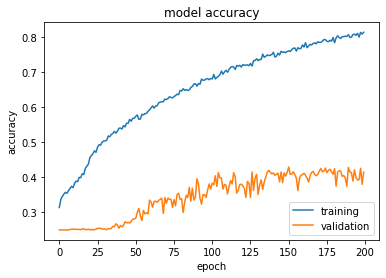

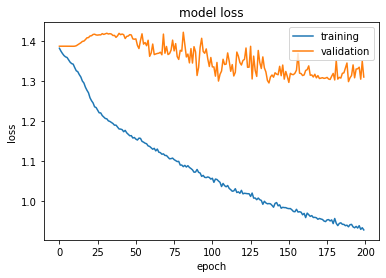

In [16]:
from matplotlib import pyplot as plt
# 学習状況のプロット関数の定義
# 分類精度の履歴をプロット
plt.plot([a.cpu() for a in acc_hist[0]])
plt.plot([a.cpu() for a in acc_hist[1]])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['training', 'validation'], loc='lower right')
plt.show()

# 損失関数の履歴をプロット
plt.plot(loss_hist[0])
plt.plot(loss_hist[1])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()


# Save the model

In [17]:
model_path = RESEARCH_WORK_PATH + 'models/multimodal2.pth'
torch.save(model.state_dict(), model_path)

# 疑問点
入力画素数はどこでわかる？